## SGDRegressor - Gradient Boosting 

- Smaller X-Variable Subset - Monte Carlo

In [1]:
import pandas as pd
import os
from datetime import timedelta
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# File paths for EUR and GBP datasets
eur_file = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\Method_1_Results\Combined_Features\Merged_Strategy_Data_EUR.csv'
gbp_file = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\Method_1_Results\Combined_Features\Merged_Strategy_Data_GBP.csv'

# Step 1: Load the EUR and GBP datasets
eur_data = pd.read_csv(eur_file)
gbp_data = pd.read_csv(gbp_file)

# Step 2: Combine the datasets by appending GBP data to EUR data
combined_data = pd.concat([eur_data, gbp_data], ignore_index=True)

# Step 3: Sort the combined data by Date, then by strategy_name
combined_data.sort_values(by=['Date', 'strategy_name'], inplace=True)

# Step 4: Define columns to keep (exclude 'classifier' and others if needed)
columns_to_keep = [
    'Date', 'strategy_name', 'Rank', 'Long_Short', 'Cumulative_VWAP', 'Cumulative_Volume', 'Precision',
    'Combined_Ratio', 'Downside_Ratio', 'Lower_Band', 'Band_Width', 'Upper_Band', 'Rolling_Mean', 
    'rolling_Peak_30', 'Close', 'EMA_4800', 'EMA_1200', 'Crossover', 'SMA_4800', 'CrossUp', 'PSAR', 
    'EMA_240', 'MACD', 'PSAR_direction', 'L14', 'PnL_slope_30', 'H14', 'TR_Smooth', 'SMA_1200', 'DM_down_Smooth', 
    'DM_up_Smooth', 'DI_up', 'Rolling_Max_Recovery_Time', 'DI_down', 'rolling_std_30', 'sharpe_ratio', 'OBV', 'K_PCT', 
    'Drawdown', 'CMF'
]

# Step 5: Filter the combined data to keep only the necessary columns
combined_data = combined_data[columns_to_keep]

# Add asset classification and encode it
combined_data['asset'] = combined_data['strategy_name'].apply(lambda x: 'EURUSD' if 'EURUSD' in x else 'GBPUSD')
combined_data['asset_binary'] = combined_data['asset'].apply(lambda x: 1 if x == 'EURUSD' else 2)

# Add Long/Short binary classification
combined_data['Long_Short_binary'] = combined_data['Long_Short'].apply(lambda x: 1 if x == 1 else -1)

# Encode strategy_name (this step must be done before creating X and y)
combined_data['strategy_encoded'] = combined_data['strategy_name'].astype('category').cat.codes

# Step 8: Define features (X) and target (y)
X = combined_data.drop(columns=['strategy_name', 'Rank'])
y = combined_data[['Date', 'Rank']]  # Keep 'Date' in y for tracking

# List of unique strategies
unique_strategies = combined_data['strategy_name'].unique()

def generate_periods_M(start_date, end_date):
    """Generate periods for walk-forward validation with 1-year training and 1-month test."""
    periods = []
    current_start = pd.to_datetime(start_date)
    final_start = pd.to_datetime(end_date)
    
    while current_start <= final_start:
        train_start = current_start
        train_end = train_start + pd.DateOffset(years=1) - timedelta(days=1)
        test_start = train_end + timedelta(days=1)
        test_end = test_start + pd.DateOffset(months=1) - timedelta(days=1)
        
        if test_end > final_start:
            break

        periods.append({
            'train_start': train_start,
            'train_end': train_end,
            'test_start': test_start,
            'test_end': test_end
        })
        
        current_start += pd.DateOffset(months=1)
    
    return periods

def slice_data_by_period(data, periods, date_col):
    """Slice data by the given periods."""
    slices = []
    for period in periods:
        train_data = data[(data[date_col] >= period['train_start']) & (data[date_col] <= period['train_end'])]
        test_data = data[(data[date_col] >= period['test_start']) & (data[date_col] <= period['test_end'])]
        slices.append((train_data, test_data))
    return slices

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('strategy', 'passthrough', ['strategy_encoded']),  # Pass through the encoded strategy
        ('asset', OneHotEncoder(), ['asset_binary']),  # One-hot encode the asset classification
        ('position', 'passthrough', ['Long_Short_binary']),  # Pass through the (-1, 1) encoded Long/Short variable
        ('numeric', StandardScaler(), X.select_dtypes(include=['float64', 'int64']).columns)  # Standardize other numeric features
    ])

# Create the pipeline for SGDRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SGDRegressor())
])

def walk_forward_validation(x_data, y_data, periods, pipeline, unique_strategies, num_runs=10):
    """Execute walk-forward validation using the provided pipeline."""
    x_data.loc[:, 'Date'] = pd.to_datetime(x_data['Date'])
    y_data.loc[:, 'Date'] = pd.to_datetime(y_data['Date'])
    
    all_predictions = []
    for run in range(num_runs):
        run_predictions = []
        
        x_slices = slice_data_by_period(x_data, periods, 'Date')
        y_slices = slice_data_by_period(y_data, periods, 'Date')

        for (x_train, x_test), (y_train, y_test) in zip(x_slices, y_slices):
            # Keep 'Date' for tracking, drop it before model fitting
            X_train = x_train.drop(columns=['Date'])
            Y_train = y_train['Rank']
            X_test = x_test.drop(columns=['Date'])
            
            # Fit the pipeline on the training data
            pipeline.fit(X_train, Y_train)
            # Make predictions on the test data
            y_pred = pipeline.predict(X_test)
            
            # Match strategy names for the test data
            test_strategies = x_test['strategy_encoded'].map(lambda x: unique_strategies[x])
            
            # Collect predictions
            period_predictions = pd.DataFrame({
                'Date': x_test['Date'],  # Retain the Date for reference
                'Strategy': test_strategies,  # Map strategy_encoded back to strategy_name
                'Model': f'SGD Run {run+1}',
                'y_actual': y_test['Rank'].values,
                'y_pred': y_pred
            })
            run_predictions.append(period_predictions)
        
        all_predictions.append(pd.concat(run_predictions))
    
    return pd.concat(all_predictions)

# Example execution (using data from walk-forward validation)
start_date = '2021-06-01'
end_date = '2023-12-31'
periods = generate_periods_M(start_date, end_date)

# Run walk-forward validation on all strategies multiple times
all_predictions = walk_forward_validation(X, y, periods, pipeline, unique_strategies, num_runs=3)

# Save the predictions to a CSV file
output_file = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\ALL_SelectBest_MC_PREDICTIONS.csv'
all_predictions.to_csv(output_file, index=False)


### Process Results

In [2]:
import pandas as pd
import os
from sklearn.metrics import mean_squared_error

# File paths
file_path = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\ALL_SelectBest_MC_PREDICTIONS.csv'
net_pnl_file_path = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\Net_PnL_Results\net_pnl_change_D.csv'
output_file = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\FINAL_MC_SelectBest.csv'

# Step 1: Load the predictions CSV
df = pd.read_csv(file_path, parse_dates=['Date'])

# Step 2: Rename the 'Strategy' column to 'strategy_name'
df.rename(columns={'Strategy': 'strategy_name'}, inplace=True)

# Step 3: Extract Month and Year from Date
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Step 4: Pivot the data to get the average y_actual and y_pred per month, year, and model
pivot_df = df.pivot_table(index=['Month', 'Year', 'Model', 'strategy_name'], values=['y_actual', 'y_pred'], aggfunc='mean').reset_index()

# Step 5: Round the predicted values to the nearest integer
pivot_df['y_pred'] = pivot_df['y_pred'].round()

# Function to get the top strategies
def get_top_strategies(pivot_df, value_column, top_n=10):
    top_strategies = {}
    for month in range(1, 13):
        for year in pivot_df['Year'].unique():
            for model in pivot_df['Model'].unique():
                subset = pivot_df[(pivot_df['Month'] == month) & (pivot_df['Year'] == year) & (pivot_df['Model'] == model)]
                top_strategies_list = subset.nlargest(top_n, value_column)['strategy_name'].unique().tolist()
                if (month, year, model) not in top_strategies:
                    top_strategies[(month, year, model)] = set()
                top_strategies[(month, year, model)].update(top_strategies_list)
    return top_strategies

# Step 6: Get the top strategies for y_actual and y_pred
top_actual_strategies = get_top_strategies(pivot_df, 'y_actual')
top_pred_strategies = get_top_strategies(pivot_df, 'y_pred')

# Step 7: Combine the strategies
combined_strategies = {}
for key in top_actual_strategies.keys():
    combined_strategies[key] = top_actual_strategies[key].union(top_pred_strategies[key])

# Step 8: Calculate MSE for the combined strategies
results = []
for (month, year, model), strategies in combined_strategies.items():
    for strategy in strategies:
        subset = pivot_df[(pivot_df['Month'] == month) & (pivot_df['Year'] == year) & (pivot_df['Model'] == model) & (pivot_df['strategy_name'] == strategy)]
        if not subset.empty:
            mse = mean_squared_error(subset['y_actual'], subset['y_pred'])
            y_actual_val = subset['y_actual'].values[0] if subset['y_actual'].values[0] != 0 else None
            y_pred_val = subset['y_pred'].values[0] if subset['y_pred'].values[0] != 0 else None
            results.append({
                'Month': month,
                'Year': year,
                'Model': model,
                'strategy_name': strategy,
                'y_actual': y_actual_val,
                'y_pred': y_pred_val,
                'MSE': mse
            })

# Step 9: Filter out rows where both y_actual and y_pred are None
results_df = pd.DataFrame(results)
results_df = results_df.dropna(subset=['y_actual', 'y_pred'], how='all')

# Step 10: Define the date range from 2022-06-01 to 2022-12-31
date_range = pd.date_range(start='2022-06-01', end='2023-12-31')

# Function to extrapolate monthly data to daily data
def extrapolate_to_daily(df):
    daily_data = []
    unique_combinations = df[['strategy_name', 'Model']].drop_duplicates()

    for _, row in unique_combinations.iterrows():
        strategy_name = row['strategy_name']
        model = row['Model']
        
        for date in date_range:
            daily_row = {
                'strategy_name': strategy_name,
                'Model': model,
                'Date': date
            }
            daily_data.append(daily_row)
    
    daily_df = pd.DataFrame(daily_data)
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
    merged_df = pd.merge(daily_df, df, on=['strategy_name', 'Model', 'Date'], how='left')
    
    return merged_df

# Step 11: Extrapolate the data to daily
daily_df = extrapolate_to_daily(results_df)

# Step 12: Group by strategy_name, Model, and Month and forward fill within each month
daily_df['Month'] = daily_df['Date'].dt.month
daily_df['Year'] = daily_df['Date'].dt.year
daily_df[['y_actual', 'y_pred', 'MSE']] = (
    daily_df.groupby(['strategy_name', 'Model', 'Month', 'Year'])[['y_actual', 'y_pred', 'MSE']].ffill()
)

# Step 13: Replace remaining NaNs with 0
# Replace NaNs with 0 for the specified columns
daily_df['y_actual'] = daily_df['y_actual'].fillna(0)
daily_df['y_pred'] = daily_df['y_pred'].fillna(0)
daily_df['MSE'] = daily_df['MSE'].fillna(0)


# Step 14: Load net PnL data and merge with the daily predictions
net_pnl_df = pd.read_csv(net_pnl_file_path, parse_dates=['Period'])
net_pnl_df.rename(columns={'Period': 'Date'}, inplace=True)
df = pd.merge(daily_df, net_pnl_df[['Date', 'strategy_name', 'net_pnl_change']],
              on=['Date', 'strategy_name'], how='inner')

# Step 15: Add a new column to represent the next month's data
df['next_month'] = df['Date'] + pd.DateOffset(months=1)
df = pd.merge(df, df[['Date', 'strategy_name', 'net_pnl_change']], 
              left_on=['next_month', 'strategy_name'], 
              right_on=['Date', 'strategy_name'], 
              suffixes=('', '_next_month'), 
              how='left')

# Step 16: Remove duplicates based on Date, strategy_name, and Model
df = df.drop_duplicates(subset=['Date', 'strategy_name', 'Model'])

# Step 17: Ensure the next_month column is properly formatted
df['next_month'] = pd.to_datetime(df['next_month'], errors='coerce')
df['next_month'] = df['next_month'].dt.month

# Step 18: Save the final dataframe to a CSV file
df.to_csv(output_file, index=False)

#### Daily Net PnL Change Graph

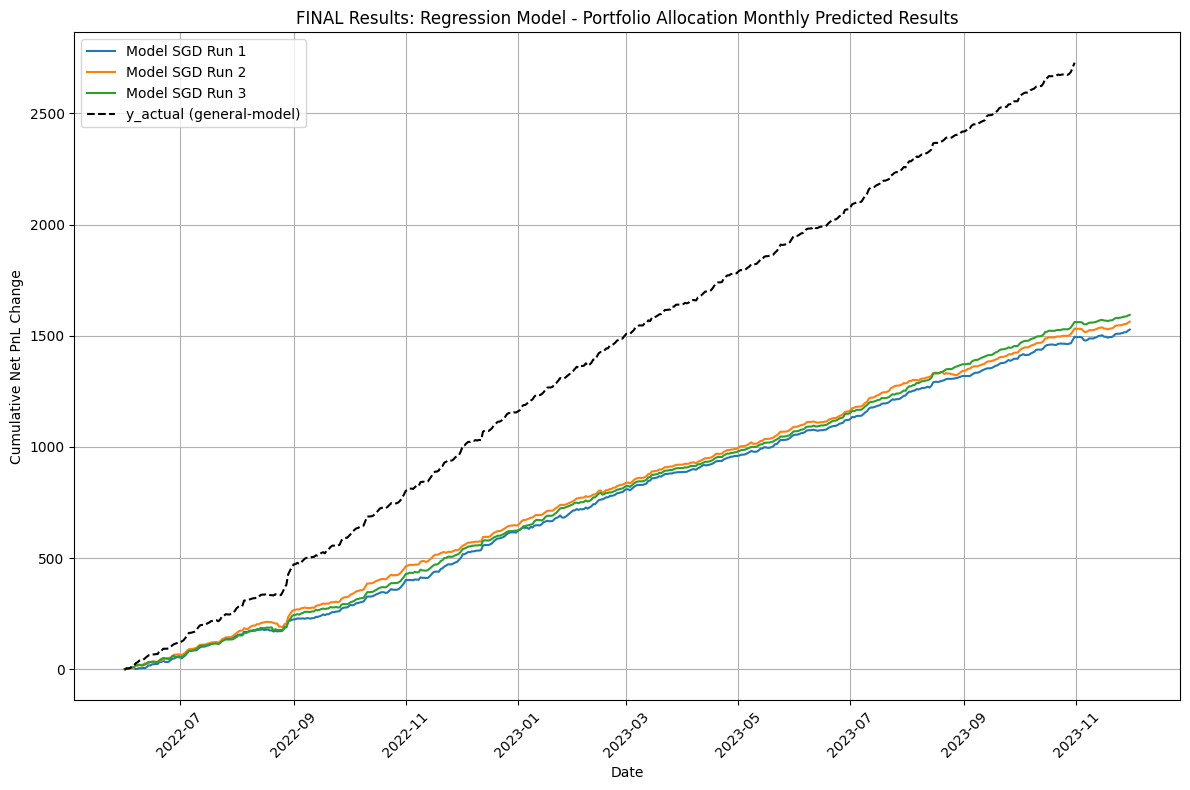

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt

file_path = r'FINAL_MC_SelectBest.csv'

# Load the CSV file
df = pd.read_csv(file_path, parse_dates=['Date'])

# Function to plot the cumulative net PnL change for each model on a daily basis
def plot_cumulative_net_pnl_change(df):
    models = df['Model'].unique()
    plt.figure(figsize=(12, 8))
    
    for model in models:
        model_df = df[df['Model'] == model]
        
        # Filter out strategies with non-zero and non-NaN y_pred
        valid_strategies = model_df[model_df['y_pred'].notna() & (model_df['y_pred'] != 0)]
        
        # Group by Date and calculate the sum of net_pnl_change and count the number of strategies
        grouped_df = valid_strategies.groupby('Date').agg(
            net_pnl_sum=('net_pnl_change_next_month', 'sum'),
            strategy_count=('net_pnl_change_next_month', 'count')
        ).reset_index()
        
        # Calculate the cumulative net_pnl_change
        grouped_df['avg_net_pnl_change'] = grouped_df['net_pnl_sum'] / grouped_df['strategy_count']
        grouped_df['cumulative_net_pnl_change'] = grouped_df['avg_net_pnl_change'].cumsum()

        # Plot the cumulative net PnL change
        plt.plot(grouped_df['Date'], grouped_df['cumulative_net_pnl_change'], label=f'Model {model}')

    # Plot y_actual (general-model)
    valid_actual_strategies = df[df['y_actual'].notna() & (df['y_actual'] != 0)]
    grouped_actual_df = valid_actual_strategies.groupby('Date').agg(
        net_pnl_sum=('net_pnl_change_next_month', 'sum'),
        strategy_count=('net_pnl_change_next_month', 'count')
    ).reset_index()
    
    grouped_actual_df['avg_net_pnl_change'] = grouped_actual_df['net_pnl_sum'] / grouped_actual_df['strategy_count']
    grouped_actual_df['cumulative_net_pnl_change'] = grouped_actual_df['avg_net_pnl_change'].cumsum()
    
    plt.plot(grouped_actual_df['Date'], grouped_actual_df['cumulative_net_pnl_change'], color='black', linestyle='--', label='y_actual (general-model)')

    plt.xlabel('Date')
    plt.ylabel('Cumulative Net PnL Change')
    plt.title('FINAL Results: Regression Model - Portfolio Allocation Monthly Predicted Results')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot cumulative net PnL change for each model and y_actual
plot_cumulative_net_pnl_change(df)


#### JSON Files of Results by Model by Period

In [4]:
import pandas as pd
import os
import json

file_path = r'FINAL_MC_SelectBest.csv'

# Load the data
df = pd.read_csv(file_path)

# Get unique models
models = df['Model'].unique()

# Iterate over each model
for model in models:
    model_df = df[df['Model'] == model]
    
    # Filter out strategies with non-zero and non-NaN y_pred
    valid_strategies = model_df[model_df['y_pred'].notna() & (model_df['y_pred'] != 0)]
    
    # Group by Month and Year and calculate the count of unique strategies
    grouped_df = valid_strategies.groupby(['Month', 'Year']).agg(
        strategy_count=('strategy_name', 'nunique')
    ).reset_index()

    # Merge the grouped_df back to valid_strategies to assign strategy_count
    merged_df = pd.merge(valid_strategies, grouped_df, on=['Month', 'Year'])

    # Drop duplicates based on strategy_name, Month, Year, and Model
    merged_df = merged_df.drop_duplicates(subset=['strategy_name', 'Month', 'Year', 'Model'])

    # Calculate allocation as 1/strategy_count
    merged_df['allocation'] = 1 / merged_df['strategy_count']

    # Sort by Month, Year, and allocation (descending)
    merged_df = merged_df.sort_values(by=['Year', 'Month', 'allocation'], ascending=[True, True, False])

    # Group by Month, Year to create separate JSON files for each period
    grouped_by_period = merged_df.groupby(['Year', 'Month'])

    for (year, month), period_df in grouped_by_period:
        # Initialize a list to store JSON objects for this period
        json_list = []
        total_allocation = 0.0  # Initialize the total allocation for the period

        # Iterate through each strategy and prepare JSON structure
        for index, row in period_df.iterrows():
            strategy_name = row['strategy_name']
            if 'GBPUSD' in strategy_name:
                currency_pair = 'GBP/USD'
            elif 'EURUSD' in strategy_name:
                currency_pair = 'EUR/USD'
            else:
                continue  # Skip if neither currency pair is found

            allocation_value = round(row['allocation'], 4)
            json_object = {
                "strategyName": strategy_name,
                "allocation": {
                    currency_pair: allocation_value
                }
            }

            json_list.append(json_object)
            total_allocation += allocation_value

        # Ensure that allocations sum to exactly 1.0000
        allocation_diff = round(1.0000 - total_allocation, 4)

        # Print the allocation_diff to check that it isn't too large
        print(f"Model: {model}, Year: {year}, Month: {month}, Allocation Difference: {allocation_diff}")

        # Adjust the last strategy's allocation to ensure the sum is exactly 1.0000
        if json_list:
            last_strategy = json_list[-1]
            last_currency_pair = list(last_strategy['allocation'].keys())[0]
            last_strategy['allocation'][last_currency_pair] = round(
                last_strategy['allocation'][last_currency_pair] + allocation_diff, 4
            )

        # Define the new folder path
        new_folder_path = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\FINAL_SUBMISSION\SGD_JSON'

        # Create the new folder if it doesn't exist
        os.makedirs(new_folder_path, exist_ok=True)

        # Define the output file path within the new folder, named after the model and period
        output_file_name = f'{model}_{year}_{str(month).zfill(2)}.json'
        output_file_path = os.path.join(new_folder_path, output_file_name)

        # Convert the list to JSON and save it to the file
        with open(output_file_path, 'w') as json_file:
            json.dump(json_list, json_file, indent=4)

Model: SGD Run 1, Year: 2022, Month: 6, Allocation Difference: -0.0
Model: SGD Run 1, Year: 2022, Month: 7, Allocation Difference: -0.0008
Model: SGD Run 1, Year: 2022, Month: 8, Allocation Difference: -0.0
Model: SGD Run 1, Year: 2022, Month: 9, Allocation Difference: -0.0
Model: SGD Run 1, Year: 2022, Month: 10, Allocation Difference: 0.0006
Model: SGD Run 1, Year: 2022, Month: 11, Allocation Difference: 0.0004
Model: SGD Run 1, Year: 2022, Month: 12, Allocation Difference: 0.0006
Model: SGD Run 1, Year: 2023, Month: 1, Allocation Difference: -0.0
Model: SGD Run 1, Year: 2023, Month: 2, Allocation Difference: -0.0
Model: SGD Run 1, Year: 2023, Month: 3, Allocation Difference: -0.0
Model: SGD Run 1, Year: 2023, Month: 4, Allocation Difference: -0.0
Model: SGD Run 1, Year: 2023, Month: 5, Allocation Difference: 0.0006
Model: SGD Run 1, Year: 2023, Month: 6, Allocation Difference: 0.0006
Model: SGD Run 1, Year: 2023, Month: 7, Allocation Difference: -0.0
Model: SGD Run 1, Year: 2023, Mo

## AdaBoostRegressor 

- Smaller X-Variable Subset - Monte Carlo

In [1]:
import pandas as pd
import os
from datetime import timedelta
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# File paths for EUR and GBP datasets
eur_file = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\Method_1_Results\Combined_Features\Merged_Strategy_Data_EUR.csv'
gbp_file = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\Method_1_Results\Combined_Features\Merged_Strategy_Data_GBP.csv'

# Step 1: Load the EUR and GBP datasets
eur_data = pd.read_csv(eur_file)
gbp_data = pd.read_csv(gbp_file)

# Step 2: Combine the datasets by appending GBP data to EUR data
combined_data = pd.concat([eur_data, gbp_data], ignore_index=True)

# Step 3: Sort the combined data by Date, then by strategy_name
combined_data.sort_values(by=['Date', 'strategy_name'], inplace=True)

# Step 4: Define columns to keep (exclude 'classifier' and others if needed)
columns_to_keep = [
    'Date', 'strategy_name', 'Rank', 'Long_Short', 'Cumulative_VWAP', 'Cumulative_Volume', 'Precision',
    'Combined_Ratio', 'Downside_Ratio', 'Lower_Band', 'Band_Width', 'Upper_Band', 'Rolling_Mean', 
    'rolling_Peak_30', 'Close', 'EMA_4800', 'EMA_1200', 'Crossover', 'SMA_4800', 'CrossUp', 'PSAR', 
    'EMA_240', 'MACD', 'PSAR_direction', 'L14', 'PnL_slope_30', 'H14', 'TR_Smooth', 'SMA_1200', 'DM_down_Smooth', 
    'DM_up_Smooth', 'DI_up', 'Rolling_Max_Recovery_Time', 'DI_down', 'rolling_std_30', 'sharpe_ratio', 'OBV', 'K_PCT', 
    'Drawdown', 'CMF'
]

# Step 5: Filter the combined data to keep only the necessary columns
combined_data = combined_data[columns_to_keep]

# Add asset classification and encode it
combined_data['asset'] = combined_data['strategy_name'].apply(lambda x: 'EURUSD' if 'EURUSD' in x else 'GBPUSD')
combined_data['asset_binary'] = combined_data['asset'].apply(lambda x: 1 if x == 'EURUSD' else 2)

# Add Long/Short binary classification
combined_data['Long_Short_binary'] = combined_data['Long_Short'].apply(lambda x: 1 if x == 1 else -1)

# Encode strategy_name (this step must be done before creating X and y)
combined_data['strategy_encoded'] = combined_data['strategy_name'].astype('category').cat.codes

# Step 8: Define features (X) and target (y)
X = combined_data.drop(columns=['strategy_name', 'Rank'])
y = combined_data[['Date', 'Rank']]  # Keep 'Date' in y for tracking

# List of unique strategies
unique_strategies = combined_data['strategy_name'].unique()

def generate_periods_M(start_date, end_date):
    """Generate periods for walk-forward validation with 1-year training and 1-month test."""
    periods = []
    current_start = pd.to_datetime(start_date)
    final_start = pd.to_datetime(end_date)
    
    while current_start <= final_start:
        train_start = current_start
        train_end = train_start + pd.DateOffset(years=1) - timedelta(days=1)
        test_start = train_end + timedelta(days=1)
        test_end = test_start + pd.DateOffset(months=1) - timedelta(days=1)
        
        if test_end > final_start:
            break

        periods.append({
            'train_start': train_start,
            'train_end': train_end,
            'test_start': test_start,
            'test_end': test_end
        })
        
        current_start += pd.DateOffset(months=1)
    
    return periods

def slice_data_by_period(data, periods, date_col):
    """Slice data by the given periods."""
    slices = []
    for period in periods:
        train_data = data[(data[date_col] >= period['train_start']) & (data[date_col] <= period['train_end'])]
        test_data = data[(data[date_col] >= period['test_start']) & (data[date_col] <= period['test_end'])]
        slices.append((train_data, test_data))
    return slices

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('strategy', 'passthrough', ['strategy_encoded']),  # Pass through the encoded strategy
        ('asset', OneHotEncoder(), ['asset_binary']),  # One-hot encode the asset classification
        ('position', 'passthrough', ['Long_Short_binary']),  # Pass through the (-1, 1) encoded Long/Short variable
        ('numeric', StandardScaler(), X.select_dtypes(include=['float64', 'int64']).columns)  # Standardize other numeric features
    ])

# Create the pipeline for SGDRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', AdaBoostRegressor())
])

def walk_forward_validation(x_data, y_data, periods, pipeline, unique_strategies, num_runs=10):
    """Execute walk-forward validation using the provided pipeline."""
    x_data.loc[:, 'Date'] = pd.to_datetime(x_data['Date'])
    y_data.loc[:, 'Date'] = pd.to_datetime(y_data['Date'])
    
    all_predictions = []
    for run in range(num_runs):
        run_predictions = []
        
        x_slices = slice_data_by_period(x_data, periods, 'Date')
        y_slices = slice_data_by_period(y_data, periods, 'Date')

        for (x_train, x_test), (y_train, y_test) in zip(x_slices, y_slices):
            # Keep 'Date' for tracking, drop it before model fitting
            X_train = x_train.drop(columns=['Date'])
            Y_train = y_train['Rank']
            X_test = x_test.drop(columns=['Date'])
            
            # Fit the pipeline on the training data
            pipeline.fit(X_train, Y_train)
            # Make predictions on the test data
            y_pred = pipeline.predict(X_test)
            
            # Match strategy names for the test data
            test_strategies = x_test['strategy_encoded'].map(lambda x: unique_strategies[x])
            
            # Collect predictions
            period_predictions = pd.DataFrame({
                'Date': x_test['Date'],  # Retain the Date for reference
                'Strategy': test_strategies,  # Map strategy_encoded back to strategy_name
                'Model': f'ABR Run {run+1}',
                'y_actual': y_test['Rank'].values,
                'y_pred': y_pred
            })
            run_predictions.append(period_predictions)
        
        all_predictions.append(pd.concat(run_predictions))
    
    return pd.concat(all_predictions)

# Example execution (using data from walk-forward validation)
start_date = '2021-06-01'
end_date = '2023-12-31'
periods = generate_periods_M(start_date, end_date)

# Run walk-forward validation on all strategies multiple times
all_predictions = walk_forward_validation(X, y, periods, pipeline, unique_strategies, num_runs=3)

# Save the predictions to a CSV file
output_file = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\ALL_ABR_PREDICTIONS.csv'
all_predictions.to_csv(output_file, index=False)


### Process Results

In [2]:
import pandas as pd
import os
from sklearn.metrics import mean_squared_error

# File paths
file_path = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\ALL_ABR_PREDICTIONS.csv'
net_pnl_file_path = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\Net_PnL_Results\net_pnl_change_D.csv'
output_file = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\FINAL_ABR.csv'

# Step 1: Load the predictions CSV
df = pd.read_csv(file_path, parse_dates=['Date'])

# Step 2: Rename the 'Strategy' column to 'strategy_name'
df.rename(columns={'Strategy': 'strategy_name'}, inplace=True)

# Step 3: Extract Month and Year from Date
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Step 4: Pivot the data to get the average y_actual and y_pred per month, year, and model
pivot_df = df.pivot_table(index=['Month', 'Year', 'Model', 'strategy_name'], values=['y_actual', 'y_pred'], aggfunc='mean').reset_index()

# Step 5: Round the predicted values to the nearest integer
pivot_df['y_pred'] = pivot_df['y_pred'].round()

# Function to get the top strategies
def get_top_strategies(pivot_df, value_column, top_n=10):
    top_strategies = {}
    for month in range(1, 13):
        for year in pivot_df['Year'].unique():
            for model in pivot_df['Model'].unique():
                subset = pivot_df[(pivot_df['Month'] == month) & (pivot_df['Year'] == year) & (pivot_df['Model'] == model)]
                top_strategies_list = subset.nlargest(top_n, value_column)['strategy_name'].unique().tolist()
                if (month, year, model) not in top_strategies:
                    top_strategies[(month, year, model)] = set()
                top_strategies[(month, year, model)].update(top_strategies_list)
    return top_strategies

# Step 6: Get the top strategies for y_actual and y_pred
top_actual_strategies = get_top_strategies(pivot_df, 'y_actual')
top_pred_strategies = get_top_strategies(pivot_df, 'y_pred')

# Step 7: Combine the strategies
combined_strategies = {}
for key in top_actual_strategies.keys():
    combined_strategies[key] = top_actual_strategies[key].union(top_pred_strategies[key])

# Step 8: Calculate MSE for the combined strategies
results = []
for (month, year, model), strategies in combined_strategies.items():
    for strategy in strategies:
        subset = pivot_df[(pivot_df['Month'] == month) & (pivot_df['Year'] == year) & (pivot_df['Model'] == model) & (pivot_df['strategy_name'] == strategy)]
        if not subset.empty:
            mse = mean_squared_error(subset['y_actual'], subset['y_pred'])
            y_actual_val = subset['y_actual'].values[0] if subset['y_actual'].values[0] != 0 else None
            y_pred_val = subset['y_pred'].values[0] if subset['y_pred'].values[0] != 0 else None
            results.append({
                'Month': month,
                'Year': year,
                'Model': model,
                'strategy_name': strategy,
                'y_actual': y_actual_val,
                'y_pred': y_pred_val,
                'MSE': mse
            })

# Step 9: Filter out rows where both y_actual and y_pred are None
results_df = pd.DataFrame(results)
results_df = results_df.dropna(subset=['y_actual', 'y_pred'], how='all')

# Step 10: Define the date range from 2022-06-01 to 2022-12-31
date_range = pd.date_range(start='2022-06-01', end='2023-12-31')

# Function to extrapolate monthly data to daily data
def extrapolate_to_daily(df):
    daily_data = []
    unique_combinations = df[['strategy_name', 'Model']].drop_duplicates()

    for _, row in unique_combinations.iterrows():
        strategy_name = row['strategy_name']
        model = row['Model']
        
        for date in date_range:
            daily_row = {
                'strategy_name': strategy_name,
                'Model': model,
                'Date': date
            }
            daily_data.append(daily_row)
    
    daily_df = pd.DataFrame(daily_data)
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
    merged_df = pd.merge(daily_df, df, on=['strategy_name', 'Model', 'Date'], how='left')
    
    return merged_df

# Step 11: Extrapolate the data to daily
daily_df = extrapolate_to_daily(results_df)

# Step 12: Group by strategy_name, Model, and Month and forward fill within each month
daily_df['Month'] = daily_df['Date'].dt.month
daily_df['Year'] = daily_df['Date'].dt.year
daily_df[['y_actual', 'y_pred', 'MSE']] = (
    daily_df.groupby(['strategy_name', 'Model', 'Month', 'Year'])[['y_actual', 'y_pred', 'MSE']].ffill()
)

# Step 13: Replace remaining NaNs with 0
# Replace NaNs with 0 for the specified columns
daily_df['y_actual'] = daily_df['y_actual'].fillna(0)
daily_df['y_pred'] = daily_df['y_pred'].fillna(0)
daily_df['MSE'] = daily_df['MSE'].fillna(0)


# Step 14: Load net PnL data and merge with the daily predictions
net_pnl_df = pd.read_csv(net_pnl_file_path, parse_dates=['Period'])
net_pnl_df.rename(columns={'Period': 'Date'}, inplace=True)
df = pd.merge(daily_df, net_pnl_df[['Date', 'strategy_name', 'net_pnl_change']],
              on=['Date', 'strategy_name'], how='inner')

# Step 15: Add a new column to represent the next month's data
df['next_month'] = df['Date'] + pd.DateOffset(months=1)
df = pd.merge(df, df[['Date', 'strategy_name', 'net_pnl_change']], 
              left_on=['next_month', 'strategy_name'], 
              right_on=['Date', 'strategy_name'], 
              suffixes=('', '_next_month'), 
              how='left')

# Step 16: Remove duplicates based on Date, strategy_name, and Model
df = df.drop_duplicates(subset=['Date', 'strategy_name', 'Model'])

# Step 17: Ensure the next_month column is properly formatted
df['next_month'] = pd.to_datetime(df['next_month'], errors='coerce')
df['next_month'] = df['next_month'].dt.month

# Step 18: Save the final dataframe to a CSV file
df.to_csv(output_file, index=False)

#### Daily Net PnL Change Graph

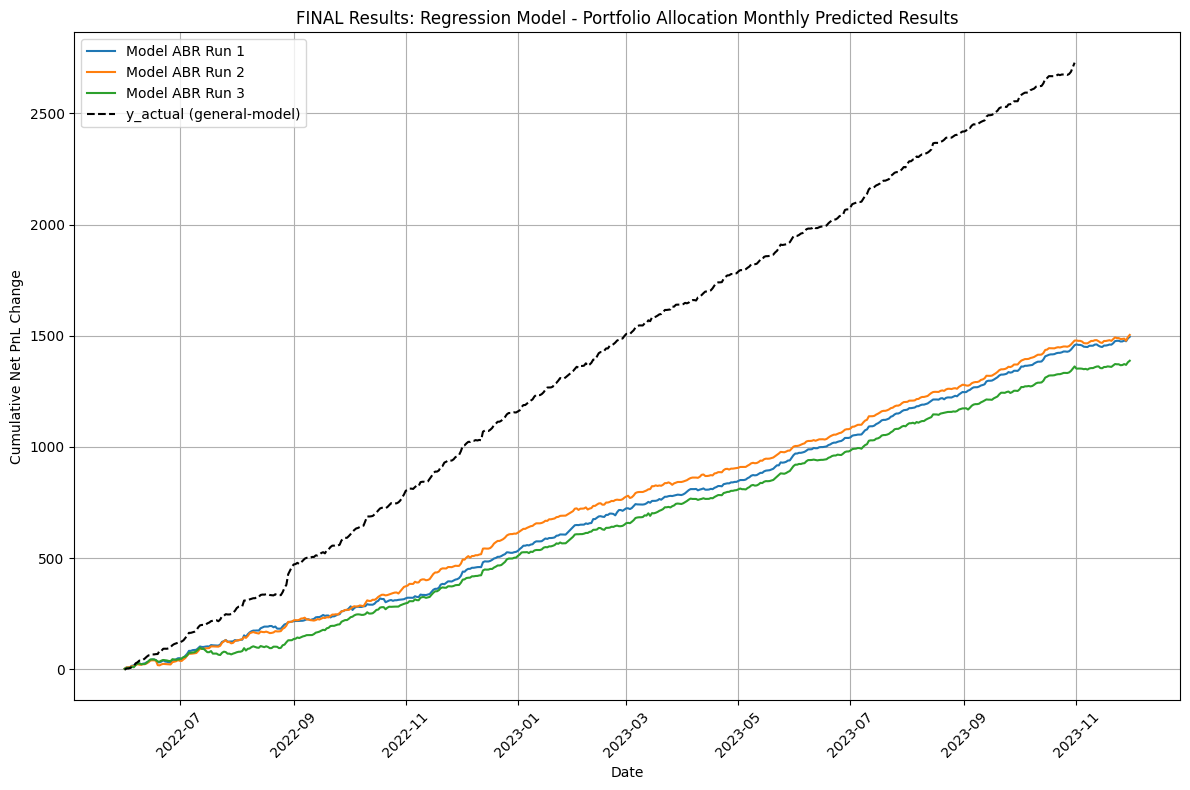

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt

file_path = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\FINAL_ABR.csv'

# Load the CSV file
df = pd.read_csv(file_path, parse_dates=['Date'])

# Function to plot the cumulative net PnL change for each model on a daily basis
def plot_cumulative_net_pnl_change(df):
    models = df['Model'].unique()
    plt.figure(figsize=(12, 8))
    
    for model in models:
        model_df = df[df['Model'] == model]
        
        # Filter out strategies with non-zero and non-NaN y_pred
        valid_strategies = model_df[model_df['y_pred'].notna() & (model_df['y_pred'] != 0)]
        
        # Group by Date and calculate the sum of net_pnl_change and count the number of strategies
        grouped_df = valid_strategies.groupby('Date').agg(
            net_pnl_sum=('net_pnl_change_next_month', 'sum'),
            strategy_count=('net_pnl_change_next_month', 'count')
        ).reset_index()
        
        # Calculate the cumulative net_pnl_change
        grouped_df['avg_net_pnl_change'] = grouped_df['net_pnl_sum'] / grouped_df['strategy_count']
        grouped_df['cumulative_net_pnl_change'] = grouped_df['avg_net_pnl_change'].cumsum()

        # Plot the cumulative net PnL change
        plt.plot(grouped_df['Date'], grouped_df['cumulative_net_pnl_change'], label=f'Model {model}')

    # Plot y_actual (general-model)
    valid_actual_strategies = df[df['y_actual'].notna() & (df['y_actual'] != 0)]
    grouped_actual_df = valid_actual_strategies.groupby('Date').agg(
        net_pnl_sum=('net_pnl_change_next_month', 'sum'),
        strategy_count=('net_pnl_change_next_month', 'count')
    ).reset_index()
    
    grouped_actual_df['avg_net_pnl_change'] = grouped_actual_df['net_pnl_sum'] / grouped_actual_df['strategy_count']
    grouped_actual_df['cumulative_net_pnl_change'] = grouped_actual_df['avg_net_pnl_change'].cumsum()
    
    plt.plot(grouped_actual_df['Date'], grouped_actual_df['cumulative_net_pnl_change'], color='black', linestyle='--', label='y_actual (general-model)')

    plt.xlabel('Date')
    plt.ylabel('Cumulative Net PnL Change')
    plt.title('FINAL Results: Regression Model - Portfolio Allocation Monthly Predicted Results')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot cumulative net PnL change for each model and y_actual
plot_cumulative_net_pnl_change(df)


#### JSON Files of Results by Model by Period

In [3]:
import pandas as pd
import os
import json

file_path = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\FINAL_ABR.csv'

# Load the data
df = pd.read_csv(file_path)

# Get unique models
models = df['Model'].unique()

# Iterate over each model
for model in models:
    model_df = df[df['Model'] == model]
    
    # Filter out strategies with non-zero and non-NaN y_pred
    valid_strategies = model_df[model_df['y_pred'].notna() & (model_df['y_pred'] != 0)]
    
    # Group by Month and Year and calculate the count of unique strategies
    grouped_df = valid_strategies.groupby(['Month', 'Year']).agg(
        strategy_count=('strategy_name', 'nunique')
    ).reset_index()

    # Merge the grouped_df back to valid_strategies to assign strategy_count
    merged_df = pd.merge(valid_strategies, grouped_df, on=['Month', 'Year'])

    # Drop duplicates based on strategy_name, Month, Year, and Model
    merged_df = merged_df.drop_duplicates(subset=['strategy_name', 'Month', 'Year', 'Model'])

    # Calculate allocation as 1/strategy_count
    merged_df['allocation'] = 1 / merged_df['strategy_count']

    # Sort by Month, Year, and allocation (descending)
    merged_df = merged_df.sort_values(by=['Year', 'Month', 'allocation'], ascending=[True, True, False])

    # Group by Month, Year to create separate JSON files for each period
    grouped_by_period = merged_df.groupby(['Year', 'Month'])

    for (year, month), period_df in grouped_by_period:
        # Initialize a list to store JSON objects for this period
        json_list = []
        total_allocation = 0.0  # Initialize the total allocation for the period

        # Iterate through each strategy and prepare JSON structure
        for index, row in period_df.iterrows():
            strategy_name = row['strategy_name']
            if 'GBPUSD' in strategy_name:
                currency_pair = 'GBP/USD'
            elif 'EURUSD' in strategy_name:
                currency_pair = 'EUR/USD'
            else:
                continue  # Skip if neither currency pair is found

            allocation_value = round(row['allocation'], 4)
            json_object = {
                "strategyName": strategy_name,
                "allocation": {
                    currency_pair: allocation_value
                }
            }

            json_list.append(json_object)
            total_allocation += allocation_value

        # Ensure that allocations sum to exactly 1.0000
        allocation_diff = round(1.0000 - total_allocation, 4)

        # Print the allocation_diff to check that it isn't too large
        print(f"Model: {model}, Year: {year}, Month: {month}, Allocation Difference: {allocation_diff}")

        # Adjust the last strategy's allocation to ensure the sum is exactly 1.0000
        if json_list:
            last_strategy = json_list[-1]
            last_currency_pair = list(last_strategy['allocation'].keys())[0]
            last_strategy['allocation'][last_currency_pair] = round(
                last_strategy['allocation'][last_currency_pair] + allocation_diff, 4
            )

        # Define the new folder path
        new_folder_path = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\FINAL_SUBMISSION\ABR_JSON'

        # Create the new folder if it doesn't exist
        os.makedirs(new_folder_path, exist_ok=True)

        # Define the output file path within the new folder, named after the model and period
        output_file_name = f'{model}_{year}_{str(month).zfill(2)}.json'
        output_file_path = os.path.join(new_folder_path, output_file_name)

        # Convert the list to JSON and save it to the file
        with open(output_file_path, 'w') as json_file:
            json.dump(json_list, json_file, indent=4)

Model: ABR Run 1, Year: 2022, Month: 6, Allocation Difference: 0.0
Model: ABR Run 1, Year: 2022, Month: 7, Allocation Difference: 0.0004
Model: ABR Run 1, Year: 2022, Month: 8, Allocation Difference: 0.0003
Model: ABR Run 1, Year: 2022, Month: 9, Allocation Difference: 0.0004
Model: ABR Run 1, Year: 2022, Month: 10, Allocation Difference: 0.0004
Model: ABR Run 1, Year: 2022, Month: 11, Allocation Difference: 0.0
Model: ABR Run 1, Year: 2022, Month: 12, Allocation Difference: 0.0004
Model: ABR Run 1, Year: 2023, Month: 1, Allocation Difference: -0.0005
Model: ABR Run 1, Year: 2023, Month: 2, Allocation Difference: 0.0
Model: ABR Run 1, Year: 2023, Month: 3, Allocation Difference: 0.0
Model: ABR Run 1, Year: 2023, Month: 4, Allocation Difference: -0.0008
Model: ABR Run 1, Year: 2023, Month: 5, Allocation Difference: -0.0005
Model: ABR Run 1, Year: 2023, Month: 6, Allocation Difference: 0.0004
Model: ABR Run 1, Year: 2023, Month: 7, Allocation Difference: 0.0006
Model: ABR Run 1, Year: 20